In [93]:
import pandas as pd
import numpy as np
import math
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [1]:
def separate_single_timeseries(df, paese, prodotto):
    filtrato = df[(df['Country'] == paese) & (df['Product'] == prodotto)]
    filtrato = filtrato.copy()
    return filtrato

def drop_leading_zeros(df):
    """
    Rimuove tutte le righe iniziali del DataFrame finché 'Quantity' == 0.
    Restituisce il DataFrame a partire dal primo valore diverso da zero.
    """
    first_nonzero_idx = df[df["Quantity"] != 0].first_valid_index()
    if first_nonzero_idx is not None:
        return df.loc[first_nonzero_idx:].reset_index(drop=True)
    else:
        return pd.DataFrame(columns=df.columns)

def ultimi_n_zeri(y, n = 5):
    y = y.reshape(-1)
    return (y[-n:] == 0).all()

def my_test_train_split(x, y, last_n_values = 12):
    x_train = x[:-last_n_values]
    x_test = x[-last_n_values:]
    y_train = y[:-last_n_values]
    y_test = y[-last_n_values:]

    return x_train, y_train, x_test, y_test

In [2]:
from scipy.signal import periodogram

def indice_periodicita_spettrale(serie):
    f, Pxx = periodogram(serie)
    Pxx = Pxx[1:]  # Escludi la frequenza 0
    if np.sum(Pxx) == 0:
        return 0
    return np.max(Pxx) / np.sum(Pxx)


def period_by_frekko(y, k):
    periods = []
    losses = []

    for k_val in k:

        li = 0
        for i in range(k_val, len(y)):
            correction = 1 if y[i] == 0 else 0
            li+=(y[i]-y[i-k_val])**2/(y[i]+ correction)

        loss = 1/(len(y)-k_val) * li

        losses.append(loss)
        periods.append(k_val)

    min_i = 0
    min_loss = losses[0]
    for i in range(1, len(periods)):
        if losses[i] < min_loss:
            min_i = i
            min_loss = losses[i]
    return min_i, min_loss

In [56]:
def probability(target_year, actual_year):
    return 1/(target_year - actual_year)**2

def prediction_w_avg(df):
    pred = []
    years = [i for i in range (2004, 2023)]
    for month in ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]:
        y_p = 0
        sum_p = 0
        for y in years:
            quantities = df.loc[((df["Month"] == f"{month}{y}")), ["Quantity"]]
            try:
                y_p = y_p + probability(2024, y)*quantities["Quantity"].iloc[0] if quantities["Quantity"].iloc[0] != 0 else y_p
                sum_p = sum_p + probability(2024, y) if quantities["Quantity"].iloc[0] != 0 else sum_p
            except:
                y_p += 0
                sum_p += 0
        
        y_p = y_p/sum_p if sum_p != 0 else y_p
        
        pred.append(int(y_p))
    return pred

In [77]:
dataframe = pd.read_csv(r"data\01_input_history.csv")
unique_countries = dataframe["Country"].unique()
unique_prods = dataframe["Product"].unique()

In [3]:
# divido il dataset per country e prodotto
# pulizia 0 iniziali
# check su peiodicità
# se periodico ---> stima prossimi picchi
# altrimenti ----> check su ultimi 0 e regressione lineare

In [99]:
def geo_w(i, N, k):
    return 1/(N//k - i + 1)

def model(df, my_model, threshold_periodicity = 0.8, periods_k = [i for i in range(1, 13)], forecast_steps = 12):
    df = drop_leading_zeros(df)
    N = len(df)
    y = df["Quantity"].values
    
    p_index = indice_periodicita_spettrale(y)

    period, periodicity_loss = period_by_frekko(y, periods_k)
    period += 1
    if periodicity_loss < threshold_periodicity:
    #if p_index < 0.35:

        if ultimi_n_zeri(y, period*2):
            predictions = [0 for _ in range(0, forecast_steps)]
        else:
            predictions = []
            den = sum([geo_w(j, N, period) for j in range(0, N//period)])
            for i in range(0, forecast_steps):
                num = sum([y[N+i-forecast_steps- period*j] * geo_w(j, N, period) for j in range(0, N//period)])
                predictions.append(num/den)
    else:
        if ultimi_n_zeri(y, 6):
            predictions = [0 for i in range(0, forecast_steps)]
        else:
            x = np.array([i for i in range(0, N)]).reshape(-1, 1)
            x_pred = np.array([i for i in range(N, N+forecast_steps)]).reshape(-1, 1)
            
            # my_model.fit(x, y)
            # predictions = my_model.predict(x_pred)

            predictions = prediction_w_avg(df)

            linreg = LinearRegression()
            linreg.fit(x[-24:], y[-24:])

            boost_param = linreg.coef_[0]

            new_predictions = []
            for pred in predictions:
                if boost_param >= 0:
                    new_predictions.append(pred * (1+ min(0.1 , abs(boost_param))))
                else:
                    new_predictions.append(pred * (1+ (-1) * min(0.1 , abs(boost_param))))
                

            
            predictions = new_predictions

    
    return predictions

In [47]:

prod = "OralEase Plus Toothbrush"
paese = "India"

reduced_dataset = separate_single_timeseries(dataframe, paese, prod)
reduced_dataset = drop_leading_zeros(reduced_dataset)

my_model = RandomForestRegressor(n_estimators=100, random_state=404, criterion="squared_error")

predictions = model(reduced_dataset, my_model)

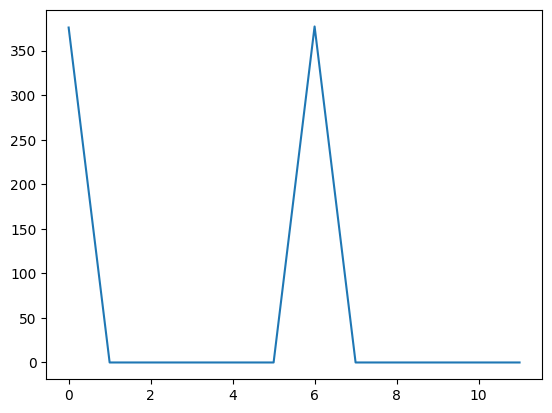

In [48]:
from matplotlib import pyplot as plt
plt.plot([i for i in range (12)], predictions)
plt.show()

In [100]:
validation_x = ["Jan2023", "Feb2023", "Mar2023", "Apr2023", "May2023", "Jun2023", "Jul2023", "Aug2023", "Sep2023", "Oct2023", "Nov2023", "Dec2023"]

df_train = pd.read_csv(r"data/01_input_history.csv")
df_train = df_train.loc[df_train["Month"].apply(lambda x : x[3:]) != 2023]


final_result = pd.DataFrame()

for country in unique_countries:
    for product in unique_prods:

        reduced_dataset = separate_single_timeseries(df_train, country, product)
        reduced_dataset = drop_leading_zeros(reduced_dataset)

        my_model = RandomForestRegressor(n_estimators=100, random_state=404, criterion="squared_error")

        predictions = model(reduced_dataset, my_model)

        result = pd.DataFrame({"Country": [country]*12, 
                                "Product": [product] *12,
                                "Month": validation_x,
                                "Quantity": predictions})
        

        final_result = pd.concat([final_result, result], ignore_index=True)


final_result.to_csv("final_result.csv", index=False)

In [85]:
dataframe = pd.read_csv(r"data\01_input_history.csv")
reference_validation = dataframe.loc[df_train["Month"].apply(lambda x : int(x[-4:])) == 2023]

reference_validation_renamed = reference_validation.rename(columns={"Quantity": "quantity_ref"})
final_result_renamed = final_result.rename(columns={"Quantity": "quantity_res"})

key_cols = ["Country", "Product", "Month"]
merged = pd.merge(reference_validation_renamed, final_result_renamed, on=key_cols, how="outer")

In [88]:
merged["error"] = merged["quantity_ref"] - merged["quantity_res"]

In [92]:
merged.loc[(merged["quantity_ref"] == 0) & (merged["error"] != 0)]

,Country,Product,Month,quantity_ref,quantity_res,error


---

In [101]:
test_x = ["Jan2024", "Feb2024", "Mar2024", "Apr2024", "May2024", "Jun2024", "Jul2024", "Aug2024", "Sep2024", "Oct2024", "Nov2024", "Dec2024"]

df_train = pd.read_csv(r"data/01_input_history.csv")

final_result = pd.DataFrame()

for country in unique_countries:
    for product in unique_prods:

        reduced_dataset = separate_single_timeseries(df_train, country, product)
        reduced_dataset = drop_leading_zeros(reduced_dataset)

        my_model = RandomForestRegressor(n_estimators=100, random_state=404, criterion="squared_error")

        predictions = model(reduced_dataset, my_model)

        result = pd.DataFrame({"Country": [country]*12, 
                                "Product": [product] *12,
                                "Month": test_x,
                                "Quantity": predictions})
        

        final_result = pd.concat([final_result, result], ignore_index=True)


final_result.to_csv("01_output_prediction_1522.csv", index=False)